In [15]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [16]:
path1 = "../../../data/curated/all_data_combined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.count()
df.printSchema()


+-----------------+------------+--------------+-------+-----------+-------------+--------------+---------------+-----------------------------+----------------------------+--------------------+--------------------+----------------------+--------------------+----------------------------+--------------------------------------+----------------------------+-----------------------------------------------+-----------------------------------------------+------------------------------------+-------------------------------------------+------------------------------------------+-------------------------------------------+------------------------------------+
|consumer_postcode|merchant_abn|order_datetime|user_id|consumer_id|consumer_name|consumer_state|consumer_gender|transaction_dollar_value_$AUD|consumer_fraud_probability_%|       merchant_name|merchant_description|merchant_revenue_level|merchant_take_rate_%|merchant_fraud_probability_%|consumer_postcode_estimated_population|consumer_postcode_m

In [18]:
# Grouping by the merchant_abn and counting the number of transactions for each merchant
from pyspark.sql import functions as F

# Aggregating to get both transaction count and total dollar value for each merchant
merchant_transaction = df.groupBy("merchant_abn").agg(
    F.count("order_datetime").alias("transaction_count"),
    F.sum("transaction_dollar_value_$AUD").alias("total_sales"),
    
)

# Converting the result to a list
merchant_transaction_list = merchant_transaction.collect()
merchant_transaction_list

[Row(merchant_abn=83412691377, transaction_count=11928, total_sales=417137.3599999998),
 Row(merchant_abn=38700038932, transaction_count=5944, total_sales=7990772.960000001),
 Row(merchant_abn=73256306726, transaction_count=4361, total_sales=1238282.0999999999),
 Row(merchant_abn=41956465747, transaction_count=244, total_sales=55116.02999999999),
 Row(merchant_abn=19839532017, transaction_count=614, total_sales=96398.0),
 Row(merchant_abn=35344855546, transaction_count=1274, total_sales=113543.56999999998),
 Row(merchant_abn=73841664453, transaction_count=811, total_sales=69372.6),
 Row(merchant_abn=92202115241, transaction_count=98, total_sales=32377.46),
 Row(merchant_abn=34440496342, transaction_count=187, total_sales=16737.53),
 Row(merchant_abn=12516851436, transaction_count=179, total_sales=27899.65),
 Row(merchant_abn=96946925998, transaction_count=110, total_sales=110545.32),
 Row(merchant_abn=15613631617, transaction_count=1483, total_sales=450504.9699999999),
 Row(merchant_ab

In [19]:
# Sorting the data by transaction count
sorted_transaction_list = sorted(merchant_transaction_list, key=lambda x: x.transaction_count)
num_unique_merchants = len(merchant_transaction_list)

# Average number of transactions
avg_transactions = sum([row.transaction_count for row in merchant_transaction_list]) / num_unique_merchants
# Minimum number of transactions
min_transactions = min([row.transaction_count for row in merchant_transaction_list])
# Maximum number of transactions
max_transactions = max([row.transaction_count for row in merchant_transaction_list])
# Quantiles (25th, 50th, and 75th percentiles)
transaction_counts = [row.transaction_count for row in merchant_transaction_list]

transaction_counts.sort()
q25 = transaction_counts[num_unique_merchants // 4]
q50 = transaction_counts[num_unique_merchants // 2]
q75 = transaction_counts[3 * num_unique_merchants // 4]
transaction_stats = {
    "Number of Unique Merchants": num_unique_merchants,
    "Average Transactions": avg_transactions,
    "Minimum Transactions": min_transactions,
    "Maximum Transactions": max_transactions,
    "25th Percentile": q25,
    "Median (50th Percentile)": q50,
    "75th Percentile": q75
}

transaction_stats


{'Number of Unique Merchants': 4026,
 'Average Transactions': 2824.8248882265275,
 'Minimum Transactions': 1,
 'Maximum Transactions': 241547,
 '25th Percentile': 78,
 'Median (50th Percentile)': 352,
 '75th Percentile': 1720}

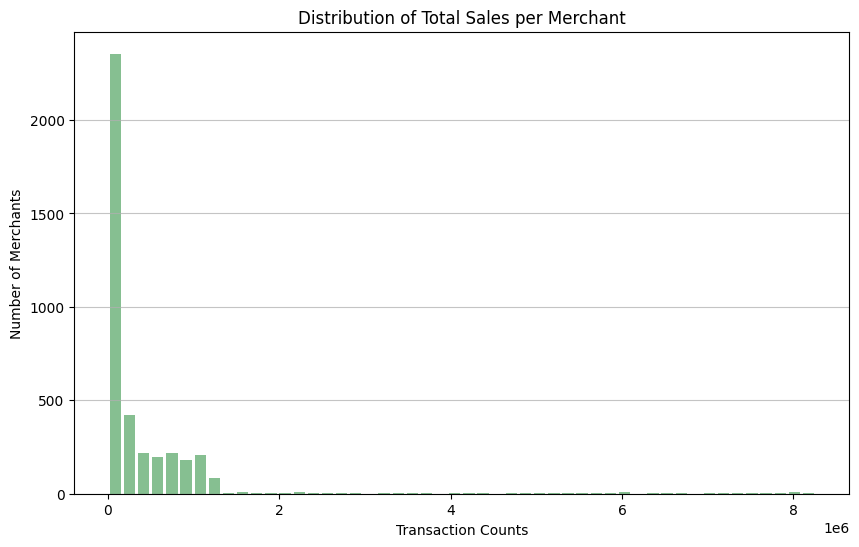

{'Number of Unique Merchants': 4025,
 'Average Sales': 447569.8484277193,
 'Minimum Sales': 6074.660000000001,
 'Maximum Sales': 8258656.869999996,
 '25th Percentile': 30579.4625,
 'Median (50th Percentile)': 118062.5,
 '75th Percentile': 526343.71}

In [20]:
total_sales_values = [row['total_sales'] for row in merchant_transaction_list]

# transaction Statistics
total_sales_transaction = {
    'Number of Unique Merchants': len(set(total_sales_values)),
    'Average Sales': sum(total_sales_values) / len(total_sales_values),
    'Minimum Sales': min(total_sales_values),
    'Maximum Sales': max(total_sales_values),
    '25th Percentile': np.percentile(total_sales_values, 25),
    'Median (50th Percentile)': np.percentile(total_sales_values, 50),
    '75th Percentile': np.percentile(total_sales_values, 75)
}

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(total_sales_values, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Total Sales per Merchant')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()


total_sales_transaction

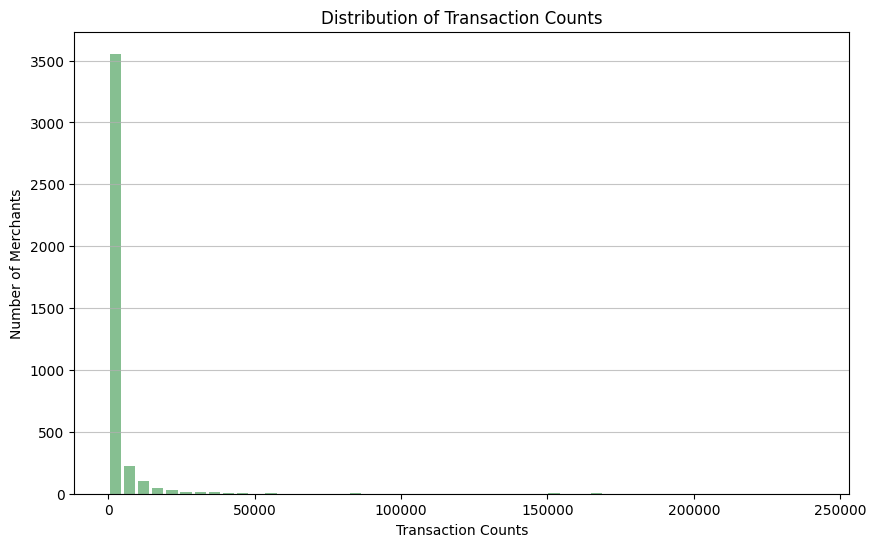

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting transaction counts for histogram
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]

plt.figure(figsize=(10,6))
plt.hist(transaction_counts, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()





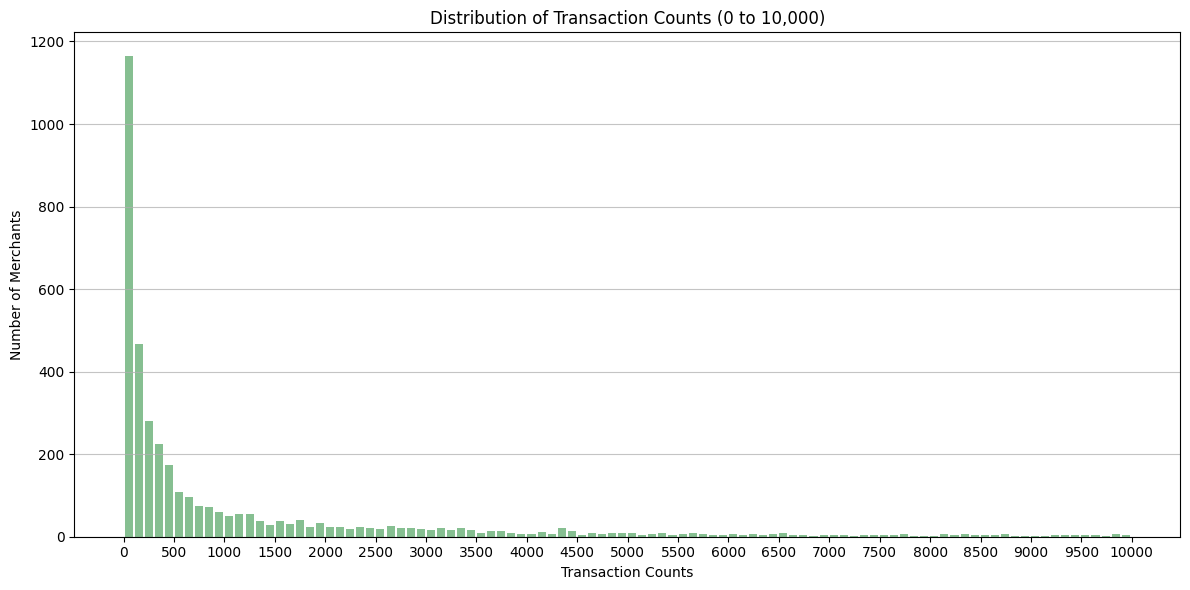

In [22]:
# Filtering transaction counts to values between 0 and 10000
filtered_transaction_counts = [count for count in transaction_counts if 0 <= count <= 10000]

plt.figure(figsize=(12,6))
plt.hist(filtered_transaction_counts, bins=100, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts (0 to 10,000)')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.xticks(np.arange(0, 10001, 500))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


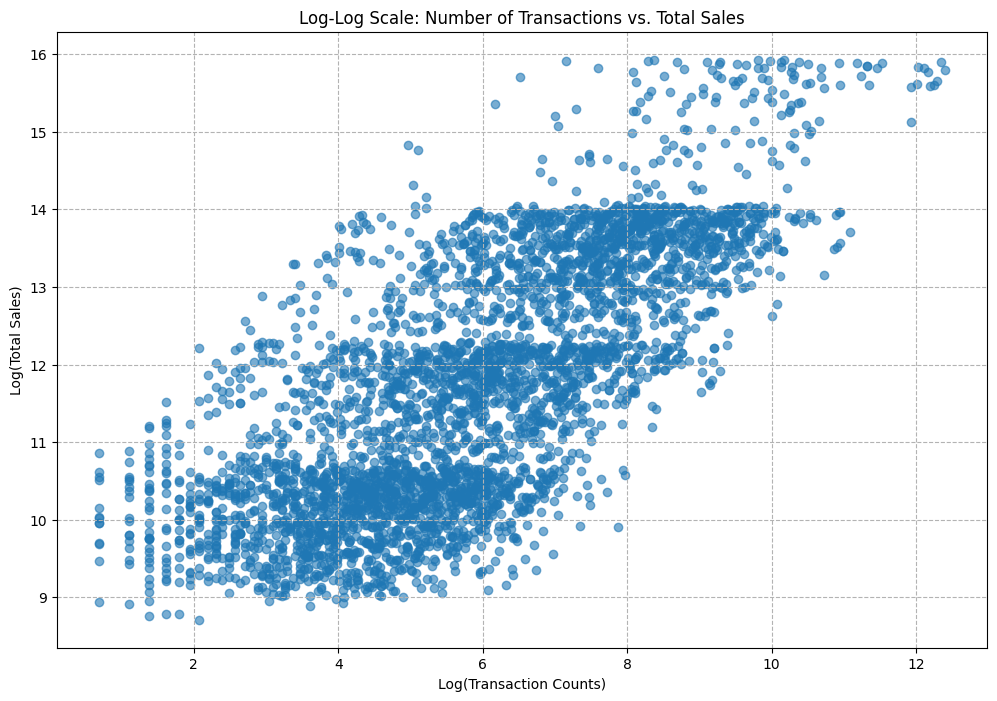

In [23]:
# Extracting transaction counts and total sales for scatter plot from the merchant_transaction_list
# Transforming data for log-log scale visualization
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]
total_sales= [row['total_sales'] for row in merchant_transaction_list]
log_transaction_counts = [np.log1p(tc) for tc in transaction_counts]
log_total_sales = [np.log1p(sales) for sales in total_sales]

plt.figure(figsize=(12, 8))
plt.scatter(log_transaction_counts, log_total_sales, alpha=0.6)
plt.title('Log-Log Scale: Number of Transactions vs. Total Sales')
plt.xlabel('Log(Transaction Counts)')
plt.ylabel('Log(Total Sales)')
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()



In [24]:
import numpy as np

# Convert transaction_counts and total_sales_values to numpy arrays for easier computations
transaction_counts_np = np.array(transaction_counts)
total_sales_values_np = np.array(total_sales_values)

# Calculate the 1% percentile values for transaction_counts and total_sales
transaction_threshold = np.percentile(transaction_counts_np, 1)
sales_threshold = np.percentile(total_sales_values_np, 1)

# Filter merchants that fall below the 1% percentile for both transaction_count and total_sales
outliers = [(merchant_transaction_list[i]['merchant_abn'], transaction_counts[i], total_sales_values[i]) 
            for i in range(len(merchant_transaction_list)) 
            if transaction_counts[i] <= transaction_threshold and total_sales_values[i] <= sales_threshold]

print(outliers)


[(51425051982, 1, 7677.63), (22019281430, 3, 7686.4), (56766066037, 2, 7468.58), (69853421807, 3, 8677.27), (64648788229, 3, 6366.2)]
